# 0. Initialize

## 0.1. Import Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

## 0.2. DEFINE VARIABLES 

In [2]:
DATA_PATH = '/Users/gorkemyar/Desktop/CS412/'

ROUND = 1 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '27970'#'<insert-your-id-here>'
PROJECT_CODE = 'CS4123fa87858939a'#'<insert-your-code-here>' # Same code for the annotation eg. CS412xxxxx

## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [3]:
#trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH))
trainingTweetDf = pd.read_csv('{}concatenated-training-tweet.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1597170281545551872,Yes
1,1431700027471192069,No
2,1566035577090281472,Yes
3,1591538690869940225,Yes
4,1583898169238167554,Yes
...,...,...
3345,1393214792236732429,No
3346,1350595871164014605,No
3347,1597990311187226629,Yes
3348,1376860568427106310,Yes


In [4]:
trainingTweetDf.isPolitical.value_counts()

Yes    2221
No     1117
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [5]:
trainingUserDf = pd.read_csv('{}concatenated-training-user.csv'.format(DATA_PATH))
#trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf

,screen_name,isBot
0,koftecancaddy,No
1,ahaber,No
2,selahat03949652,No
3,erdin06357062,No
4,bhct__necatii,No
...,...,...
3413,ayse_akarevli,Yes
3414,senin_le,No
3415,allahsevenli,Yes
3416,ariza5834,No


In [6]:
trainingUserDf.isBot.value_counts()

No     2717
Yes     701
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [7]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/Annotation-CS412-202201/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/Annotation-CS412-202201/reports/report_CS4123fa87858939a.html


# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [8]:
PATH_TO_DOWNLOADED = DATA_PATH # 'D:/Users/suuser/Desktop/Sabancı/CS412/spring-2022/project/'

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [9]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [10]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [11]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [12]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [13]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [14]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']
    user_follower = tweet_metadata_line['user']['followers_count']
    user_total_tweet = tweet_metadata_line['user']['statuses_count']
    return id, screen_name, description, user_follower, user_total_tweet

#### 1.1.1.7 User name numeric characters

In [15]:
def numeric_character_count(text):
    return sum(c.isdigit() for c in text)

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [16]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['rterdogan', 'mansuryavas06', 'ekrem_imamoglu', 'dbdevletbahceli', 'meral_aksener', 'kilicdarogluk', 
                        'drfahrettinkoca', 'suleymansoylu', 'umitozdag', 'vekilince', 't_karamollaoglu', 'dogu_perincek', 
                        'vedatbilgn', 'ahmet_davutoglu', 'fuatoktay', 'fahrettinaltun', 'nureddinnebati', 'vahitkirisci', 
                        'akparti', '06melihgokcekvatan', 'türkiye', 'parti', 'bayrak', 'millet', 'CHP', 'AKP', 'iyi parti',
                        'demokrasi', 'devlet', 'meclispolitika', 'oy', 'seçim', 'cumhuriyet', 'adalet', 'ekonomi', 'sağlık', 
                        'eğitim', 'hak', 'dolar', 'atama', 'kadro', 'milletvekili', 'ülke', 'bakan', '06melihgokcek', 'tcbestepe', 
                        'varank', 'bekirpakdemirli', 'akaraismailoglu', 'alpayozalan35', 'kasapoglu', 'murat_kurum', 'tc_icisleri', 
                        'akkadinistanbul', 'herkesicinchp', 'ibbhabercomtr', 'mevlutcavusoglu', 'tcbuyuksehir', 'mhp_bilgi', 'deryayanikashb', 
                        'erkankandemir', 'ayyildirim1', 'rtedijital', 'azpresident', 'aysekesir', 'abdulhamitgul', 'gergerliogluof', 'tc_disisleri', 
                        'rbklndr', 'osmannnurika', 'mehmedmus', 'gazetesozcu', 'omerrcelik', 'e_semihyalcin', 'mehmetay01', 'fatmasahin', 'yildiraycicek9',
                        'csbgovtr', 'ahmetsceylan', 'tokcem', 'muratsahin2023', 'ziyaselcuk', 'fatih_donmez']
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [17]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

#### 1.1.2.3 Retweeted from a Politician

In [18]:
def is_retweeted_user_politician(username):
    
    political_figures = ['rterdogan', 'mansuryavas06', 'ekrem_imamoglu', 'dbdevletbahceli', 'meral_aksener', 'kilicdarogluk', 
                        'drfahrettinkoca', 'suleymansoylu', 'umitozdag', 'vekilince', 't_karamollaoglu', 'dogu_perincek', 
                        'vedatbilgn', 'ahmet_davutoglu', 'fuatoktay', 'fahrettinaltun', 'nureddinnebati', 'vahitkirisci', 
                        'akparti', '06melihgokcekvatan', 'türkiye', 'parti', 'bayrak', 'millet', 'CHP', 'AKP', 'iyi parti',
                        'allah', 'din', 'türk', 'demokrasi', 'devlet', 'meclispolitika', 'oy', 'seçim', 'cumhuriyet', 'adalet',
                        'haksızlık', 'ekonomi', 'sağlık', 'eğitim', 'hak', 'dolar', 'atama', 'kadro', 'milletvekili', 'ülke',
                        'bakan', '06melihgokcek', 'tcbestepe', 'varank', 'bekirpakdemirli', 'akaraismailoglu', 'alpayozalan35',
                        'kasapoglu', 'murat_kurum', 'tc_icisleri', 'akkadinistanbul', 'herkesicinchp', 'ibbhabercomtr', 'mevlutcavusoglu',
                        'tcbuyuksehir', 'mhp_bilgi', 'deryayanikashb', 'erkankandemir', 'ayyildirim1', 'rtedijital', 'azpresident',
                        'aysekesir', 'abdulhamitgul', 'gergerliogluof', 'tc_disisleri', 'rbklndr', 'osmannnurika', 'mehmedmus',
                        'gazetesozcu', 'omerrcelik', 'e_semihyalcin', 'mehmetay01', 'fatmasahin', 'yildiraycicek9', 'csbgovtr',
                        'ahmetsceylan', 'tokcem', 'muratsahin2023', 'ziyaselcuk', 'fatih_donmez']
    
    is_politician = 0;
    
    
    if ( username is not None and username.lower() in political_figures):
        is_politician = 1;
       
        
    return is_politician

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [19]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'is_retweeted_user_politician': [],
              'text':[],
              'text_length': [],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'user_tweet_count': [],
               'user_follower_count': [],
               'user_description_political':[],
              'num_political_entities':[],
              'total_interactions':[],
              'name_numeric_character_count':[]
              }


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    i = 0
    for line in f:
        
        i = i+1
        
        line = json.loads(line)
        
   
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description, user_follower, user_total_tweet = get_user_info(line)
        

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        description = line['user']['description']
        user_description_political = check_political_ent(description)
        total_num_interactions = total_interactions(retweet_count, favorite_count)
        retweeted_user_politician = is_retweeted_user_politician(retweeted_username)
        text_length = len(text)
        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['is_retweeted_user_politician'].append(retweeted_user_politician)
        dfPolitical['text'].append(text)
        dfPolitical['text_length'].append(text_length)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['user_follower_count'].append(user_follower)
        dfPolitical['user_tweet_count'].append(user_total_tweet)
        dfPolitical['user_description_political'].append(user_description_political)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['name_numeric_character_count'].append(numeric_character_count(screen_name))

In [20]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical


,tweet_id,is_retweet,retweeted_username,is_retweeted_user_politician,text,text_length,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,user_tweet_count,user_follower_count,user_description_political,num_political_entities,total_interactions,name_numeric_character_count
0,1588568792984346624,0,None,0,"Sosyal Hizmetin temelini çocuk oluşturur,çocuğ...",140,0,0,49,98,920963718103650304,maviruh_,shu/\nburaya afilli bir söz yazdığımı varsayın,2638,284,0,1,147,0
1,1588452263047069697,0,None,0,"@mahirunal Gavur İzmir ya onlar, hani Cumhuriy...",97,1,0,0,0,595514060,mtfdan,,6647,131,0,1,0,0
2,1569589330544398336,0,None,0,#ŞehitAdayıUzmÇvşaKadro\nSiz İstesenizde Istem...,140,0,1,0,0,1356375754561490947,ahsucilginuzman,Vatan Sevdalisi,2924,60,0,1,0,0
3,1570428119609139201,0,None,0,@ajans_muhbir Siz kaypak olmayıp onay vermesey...,140,1,0,0,0,1478775431008595968,hamitelkelle,HighOne,1783,2,0,0,0,0
4,1551163840368414722,0,None,0,Engelli öğretmenler olarak önümüzdeki engeller...,140,0,0,0,0,1511976696337113088,sed58417690,,7559,119,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33528,1568595408233832448,0,None,0,Gerçek kimlik taşımayan hesaplara cevap vermem...,140,0,0,9,81,576247173,ardanzenturk,RT ONAYLADIĞIM ANLAMINA GELMEZ\nArtık fikirler...,41342,171399,0,0,90,0
33529,1584027427696959488,0,None,0,@umitozdag Neden Suriyelilerle ilgili bu kadar...,140,1,0,1,8,162308585,ozgul_61,Bridge design engineer Yaay hesabı : dilfiruz,52340,3936,0,1,9,2
33530,1585945783307730945,0,None,0,@celebimehmeta Niye Türkiye yüzyılıda.Türkiye ...,76,1,0,0,1,415025519,ladrekova,,1225,121,0,2,1,0
33531,1569748909521801221,1,muazzezeralp,0,RT @muazzezeralp: @Doan58213655 @denizkonur @N...,140,7,1,6,0,1442125177727307781,yapikytgrivrlsn,,153819,591,0,2,6,0


## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.0 Average Tweets


##### 1.2.1.0.1 Format Month

In [21]:
def format_month(month):
  month = month.lower()
  if month == "jan":
      return 1
  elif month == "feb":
      return 2
  elif month == "mar":
      return 3     
  elif month == "apr":
      return 4     
  elif month == "may":
      return 5     
  elif month == "jun":
      return 6     
  elif month == "jul":
      return 7     
  elif month == "aug":
      return 8     
  elif month == "sep":
      return 9     
  elif month == "oct":
      return 10     
  elif month == "nov":
      return 11
  elif month == "dec":
      return 12
  else:
      return -1;

##### 1.2.1.0.2 Get Created Time


In [22]:
from datetime import date
def get_created_time(created_time_str):
  # format = Thu Oct 19 10:43:55 +0000 2017
  time_list = created_time_str.split(" ")
  year, month, day, time = time_list[-1], format_month(time_list[1]), time_list[2], time_list[3]
  time = time.split(":")
  hour, minute, seconds = time[0], time[1], time[2]
  datetime_object = date(int(year), int(month), int(day));
  return datetime_object


##### 1.2.1.0.3 Average Tweet Per Day

In [23]:
def average_time_per_day(created_at, tweet_count):
  created_date = get_created_time(created_at)
  today = date.today()
  day_count = (today - created_date).days
  average = tweet_count / day_count
  return average


#### 1.2.1.1. Get user info metadata

In [24]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']

    user_tweet_count = user_metadata_line['statuses_count']
    user_created_at = user_metadata_line['created_at']

    user_average_tweet_day = average_time_per_day(user_created_at, user_tweet_count)

    user_favourites_count = user_metadata_line['favourites_count']

    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count,
      'user_tweet_count': user_tweet_count, 'user_average_tweet_day':user_average_tweet_day, 'user_favourites_count': user_favourites_count}

      

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [25]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [26]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

In [27]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
         'user_tweet_count': [],
         'user_average_tweet_day': [],
         'user_favourites_count':[]}

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

In [28]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_tweet_count,user_average_tweet_day,user_favourites_count
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,2551,5.031558,17676
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,42771,49.907818,15474
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,14300,10.384895,18220
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,21303,8.373821,26999
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,1629,0.488749,2179
...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,2396,2.950739,10820
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,75178,15.893869,36671
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,6482,1.294329,7389
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,121113,37.496285,140095


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [29]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.2. Check median number of favorites

In [30]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

#### 1.2.2.3 Unique Tweet Ratio

In [31]:
def unique_tweets_ratio(line):
  if len(line['tweets']) == 0: 
    return 1
  tweets = set()
  for tweet in line['tweets']:
    if tweet['text'] not in tweets:
      tweets.add(tweet['text'])
  return len(tweets) / len(line['tweets'])

1.2.2.4 Mention Ratio

In [32]:
def mention_hashtag_ratio(line):
  if len(line['tweets']) == 0: 
    return 0, 0, 0
  tweets = set()
  mention = 0
  hashtag = 0
  tweet_len = 0
  for tweet in line['tweets']:
    tweet_len += len(tweet['text'])
    mention += tweet['text'].count('@')
    hashtag += tweet['text'].count('#')
  return mention / len(line['tweets']), hashtag / len(line['tweets']), tweet_len / len(line['tweets'])

#### 1.2.2.5 Retweeted from Unique Users Ratio

In [33]:
def retweet_unique_user_ratio(line):
    if len(line['tweets']) == 0: 
        return 1
    users = set()
    retweets = 0
    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            retweets += 1
            users.add(tweet['retweeted_status']['user']['screen_name'].lower())
        except:
            pass
    if len(users) == 0:
        return 1
    return retweets / len(users)

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [34]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[],
               'unique_tweet_ratio':[],
               'mention_ratio':[],
               'hashtag_ratio':[],
               'retweet_unique_user_ratio':[],
                'tweet_len_ratio':[]
              }

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:
        
        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)
        
        dfBotTweets['num_of_tweets'].append(len(line['tweets']))
  
        dfBotTweets['unique_tweet_ratio'].append(unique_tweets_ratio(line))
        
        mention_ratio, hashtag_ratio, tweet_len_ratio = mention_hashtag_ratio(line)
        dfBotTweets['mention_ratio'].append(mention_ratio)
        dfBotTweets['hashtag_ratio'].append(hashtag_ratio)
        dfBotTweets['tweet_len_ratio'].append(tweet_len_ratio)
        dfBotTweets['retweet_unique_user_ratio'].append(retweet_unique_user_ratio(line))

        i += 1
        if i % 1000 == 0:
            print(i)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [36]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets,unique_tweet_ratio,mention_ratio,hashtag_ratio,retweet_unique_user_ratio,tweet_len_ratio
0,594642154,0.115000,2.0,200,1.000000,0.745000,0.005000,1.095238,87.340000
1,525600289,0.005025,1.0,199,0.984925,1.115578,0.100503,1.000000,49.351759
2,931895965501534209,0.900000,0.0,200,0.875000,2.080000,0.870000,2.432432,132.025000
3,1591543462746329088,0.185000,0.0,200,0.995000,2.350000,0.065000,2.466667,119.200000
4,734801354749796352,1.000000,0.0,200,1.000000,1.060000,0.115000,1.801802,122.155000
...,...,...,...,...,...,...,...,...,...
28310,1591370361488252928,0.800000,0.0,200,0.975000,1.455000,0.515000,3.076923,128.135000
28311,1475272459616235525,0.825000,0.0,200,1.000000,2.075000,0.230000,1.352459,119.580000
28312,1096753792731750401,0.051020,1.0,196,1.000000,0.969388,0.020408,1.428571,69.673469
28313,1269527617687953409,0.095000,2.0,200,1.000000,0.340000,0.005000,1.055556,51.130000


### 1.2.3. Merge dfBot and dfBotTweets

In [37]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')


print(dfBotAll.isna().sum())
#dfBotAll[['retweet_total_ratio', 'num_median_favorites', 'hashtag_ratio', 'tweet_len_ratio', 'unique_tweet_ratio']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites','hashtag_ratio', 'tweet_len_ratio', 'unique_tweet_ratio']].fillna(0)
print(dfBotAll.shape)
dfBotAll

user_id                         0
user_name                       0
user_screen_name                0
user_location                   0
user_description                0
user_followers_count            0
user_friends_count              0
description_len                 0
followers_to_all_ratio          0
user_tweet_count                0
user_average_tweet_day          0
user_favourites_count           0
retweet_total_ratio          1438
num_median_favorites         1438
num_of_tweets                1355
unique_tweet_ratio           1355
mention_ratio                1355
hashtag_ratio                1355
retweet_unique_user_ratio    1355
tweet_len_ratio              1355
dtype: int64
(29670, 20)


,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_tweet_count,user_average_tweet_day,user_favourites_count,retweet_total_ratio,num_median_favorites,num_of_tweets,unique_tweet_ratio,mention_ratio,hashtag_ratio,retweet_unique_user_ratio,tweet_len_ratio
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,2551,5.031558,17676,0.395939,0.0,197.0,1.000000,1.274112,0.096447,1.471698,72.126904
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,42771,49.907818,15474,0.125000,0.0,200.0,1.000000,0.840000,0.000000,1.190476,39.605000
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,14300,10.384895,18220,0.910000,0.0,200.0,0.995000,2.750000,1.240000,3.956522,121.570000
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,21303,8.373821,26999,0.015306,1.0,196.0,1.000000,0.290816,0.010204,1.000000,83.020408
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,1629,0.488749,2179,0.659898,0.0,197.0,1.000000,0.923858,0.446701,1.625000,119.421320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,2396,2.950739,10820,0.015000,1.0,200.0,0.995000,1.225000,0.040000,1.500000,70.435000
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,75178,15.893869,36671,0.291457,2.0,199.0,0.994975,0.778894,0.085427,1.260870,88.246231
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,6482,1.294329,7389,0.061538,0.0,195.0,1.000000,1.148718,0.051282,1.000000,42.805128
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,121113,37.496285,140095,0.995000,0.0,200.0,1.000000,1.090000,0.045000,3.209677,129.175000


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [293]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head(30)


,tweet_id,is_retweet,retweeted_username,is_retweeted_user_politician,text,text_length,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,user_tweet_count,user_follower_count,user_description_political,num_political_entities,total_interactions,name_numeric_character_count,isPolitical
0,1588568792984346624,0,None,0,"Sosyal Hizmetin temelini çocuk oluşturur,çocuğ...",140,0,0,49,98,920963718103650304,maviruh_,shu/\nburaya afilli bir söz yazdığımı varsayın,2638,284,0,1,147,0,Yes
1,1588452263047069697,0,None,0,"@mahirunal Gavur İzmir ya onlar, hani Cumhuriy...",97,1,0,0,0,595514060,mtfdan,,6647,131,0,1,0,0,Yes
2,1569589330544398336,0,None,0,#ŞehitAdayıUzmÇvşaKadro\nSiz İstesenizde Istem...,140,0,1,0,0,1356375754561490947,ahsucilginuzman,Vatan Sevdalisi,2924,60,0,1,0,0,Yes
3,1570428119609139201,0,None,0,@ajans_muhbir Siz kaypak olmayıp onay vermesey...,140,1,0,0,0,1478775431008595968,hamitelkelle,HighOne,1783,2,0,0,0,0,Yes
4,1551163840368414722,0,None,0,Engelli öğretmenler olarak önümüzdeki engeller...,140,0,0,0,0,1511976696337113088,sed58417690,,7559,119,0,0,0,8,Yes
5,1593649159009099777,0,None,0,@kilicdarogluk İşin gücün manipilasyon bay Kemal,48,1,0,0,1,805866821693874176,ahmetbaran70,TÜRKİYE sevdalısı.T.S.K,5687,123,0,1,1,2,Yes
6,1434787703783051264,0,None,0,@vmintr_vmin Annem bu evde yaşamaz o kadar cam...,104,1,0,0,0,1025389451546165254,jerviajeon,Ben konuşamam my time - fan account,23060,740,0,0,0,0,No
7,1367571642604544000,0,None,0,@BarisTahmaz @MuratKeskin75 @emreakduz Koptum ...,51,3,0,0,0,947887032277364741,bakidiren,,12930,262,0,0,0,0,No
8,1592440587923632128,0,None,0,@alimahir Kravatta değişmiş,27,1,0,0,0,925094562145677312,azizerguven,,3642,324,0,0,0,0,No
9,1594246341969985544,0,None,0,"@dfikrisaglar Kız değil erkek, Ayşe değil İsma...",88,1,0,0,0,2865530388,ibrahimavcu10,🇹🇷DAİMA DAHA GÜÇLÜ BİR TÜRKİYE İÇİN DEVLETİNİN...,2438,248,1,0,0,2,Yes


### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [294]:
X = dfPoliticalAll_train[['text_length','num_mentions', 'user_description_political','num_political_entities'
                        ,'num_hashtags',  'total_interactions', 'name_numeric_character_count']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

X.head(10)



,text_length,num_mentions,user_description_political,num_political_entities,num_hashtags,total_interactions,name_numeric_character_count
0,140,0,0,1,0,147,0
1,97,1,0,1,0,0,0
2,140,0,0,1,1,0,0
3,140,1,0,0,0,0,0
4,140,0,0,0,0,0,8
5,48,1,0,1,0,1,2
6,104,1,0,0,0,0,0
7,51,3,0,0,0,0,0
8,27,1,0,0,0,0,0
9,88,1,1,0,0,0,2


#### 2.1.2.0 Oversampling

In [295]:
print("Before OverSampling, counts of label '1': {}".format(sum( y== 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X, y.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))

Before OverSampling, counts of label '1': 2221
Before OverSampling, counts of label '0': 1129 

After OverSampling, the shape of train_X: (4442, 7)
After OverSampling, the shape of train_y: (4442,) 

After OverSampling, counts of label '1': 2221
After OverSampling, counts of label '0': 2221


### 2.1.3. Train - validation split

In [309]:
from sklearn.model_selection import train_test_split

X_temp, X_valid, y_temp, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42) 

In [310]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(2144, 7) (2144,)
(536, 7) (536,)
(670, 7) (670,)


#### 2.1.3.0 Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# import xgboost as xgb
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 5, 7, 10, 12,15],
#         'min_child_weight': [1, 3, 5, 7],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.3,0.4, 0.5, 0.7],
#         'n_estimators' : [100],
#         'objective': ['reg:squarederror']
#     }

#     xgb_model = xgb.XGBClassifier()

#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            #scoring = 'neg_mean_absolute_error', #MAE
#                            scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

#     gsearch.fit(X_train,y_train)
#     return gsearch.best_params_
# best_params = hyperParameterTuning(X_train,y_train)
# print(best_params)

### 2.1.5. NLP _ Pretrain

In [311]:
### data ###
X_nlp = dfPoliticalAll_train[['text']]
y_nlp = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

In [312]:
print(X_nlp.isna().sum())

text    0
dtype: int64


In [313]:
X_train_nlp, X_valid_nlp, y_train_nlp, y_valid_nlp = train_test_split(X_nlp, y_nlp, test_size=0.2, random_state=42)
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(X_train_nlp, y_train_nlp, test_size=0.2, random_state=42)

In [314]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_nlp['text'])
X_train_counts.shape

(2144, 11182)

In [315]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2144, 11182)

In [316]:
print(X_train_tfidf)

  (0, 9075)	0.46110358912647886
  (0, 7216)	0.437668225563001
  (0, 5620)	0.2344185570879154
  (0, 5079)	0.36257133437301897
  (0, 3801)	0.3280171219778315
  (0, 1523)	0.421040570497787
  (0, 1478)	0.35291582239293284
  (1, 9318)	0.25886119134841235
  (1, 7485)	0.25886119134841235
  (1, 7139)	0.24570469837203465
  (1, 6966)	0.25886119134841235
  (1, 5246)	0.25886119134841235
  (1, 4691)	0.05148406450982719
  (1, 2748)	0.2291294774791973
  (1, 2691)	0.17322931199054944
  (1, 2534)	0.25886119134841235
  (1, 2240)	0.05148406450982719
  (1, 1963)	0.5177223826968247
  (1, 1813)	0.1825639923118755
  (1, 1812)	0.1981251336676988
  (1, 1602)	0.15377286326154876
  (1, 1480)	0.24570469837203465
  (1, 1411)	0.24570469837203465
  (1, 4)	0.17823117847892342
  (2, 9148)	0.46832315084229026
  :	:
  (2142, 4815)	0.25907123004959276
  (2142, 4691)	0.0634972311438436
  (2142, 4219)	0.31926323334637663
  (2142, 3298)	0.31926323334637663
  (2142, 2240)	0.0634972311438436
  (2142, 1350)	0.1912548321499963


In [317]:
## import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(X_train_nlp['text'], y_train_nlp)

In [318]:
predicted = text_clf.predict(X_valid_nlp['text'])
np.mean(predicted == y_valid_nlp)

0.6865671641791045

In [319]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='squared_error', penalty='l2',
                                            alpha=1e-3,  random_state=42)),
])
_ = text_clf_svm.fit(X_train_nlp['text'], y_train_nlp)
predicted_svm = text_clf_svm.predict(X_valid_nlp['text'])
predicted_svm_test = text_clf_svm.predict(X_test_nlp['text'])
print (predicted_svm)
accuracy_score(y_valid_nlp, predicted_svm)

[1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1
 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0
 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 0 1 0 1 1 1 1 1 1 1 0 

0.7746268656716417

In [320]:
### update data ###
temp1 = pd.DataFrame({"nlp_prediction":predicted_svm}
                         ,index=X_valid.index)
temp2 = pd.DataFrame({"nlp_prediction":predicted_svm_test}
                            ,index=X_test.index)
X_valid_nlp_scores = X_valid.join(temp1)
X_test_nlp_scores = X_test.join(temp2)

In [287]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train_nlp['text'], y_train_nlp)

Error processing line 1 of /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/vision-1.0.0-py3.9-nspkg.pth:

Error processing line 1 of /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importl

In [288]:
gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

In [289]:
best_clf = gs_clf.best_estimator_

accuracy_score(y_valid_nlp, best_clf.predict(X_valid_nlp['text']))

0.7223880597014926

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [155]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns
# {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
xg_political = xgb.XGBClassifier(learning_rate=0.01,
                          max_depth=7,
                          colsample_bytree= 0.5,
                          min_child_weight= 7,
                          subsample= 0.7,

                          objective="reg:squarederror",
                          n_estimators=100)

xg_political.fit(X_train, y_train)

y_pred = xg_political.predict(X_valid)
y_pred_test = xg_political.predict(X_test)

y_pred_df = pd.DataFrame({"xg_prediction":y_pred}
                         ,index=X_valid.index)

y_pred_test_df = pd.DataFrame({"xg_prediction":y_pred_test}
                            ,index=X_test.index)


X_ada_valid = X_valid.join(y_pred_df)
X_ada_test = X_test.join(y_pred_test_df)

In [321]:
#### ADABOOST ####
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
# Create the base model
base_model_1 = DecisionTreeRegressor()
base_model_2 = LinearRegression()
base_model_3 = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
base_model_4 = SVR()


# Create the ensemble model
ensemble_model = AdaBoostRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, loss="linear")

# Fit the ensemble model to the training data
ensemble_model.fit(X_valid_nlp_scores, y_valid)

# Predict using the ensemble model on the test data
y_pred = ensemble_model.predict(X_test_nlp_scores)
y_pred = [0 if x < 0 else x for x in y_pred]
y_pred = [1 if x > 1 else x for x in y_pred]

# Evaluate the ensemble model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.4f}".format(mse))


Mean Squared Error: 0.1547


Mean squared error for train set is 0.19617224880382775
Mean squared error for test set is 0.21597300337457817
Accuracy Score: 0.7840269966254219
Confusion Matrix: 
 [[363  97]
 [ 95 334]]
[0.04887292 0.10969569 0.03136261 0.72910744 0.02275477 0.01877256
 0.03943401]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

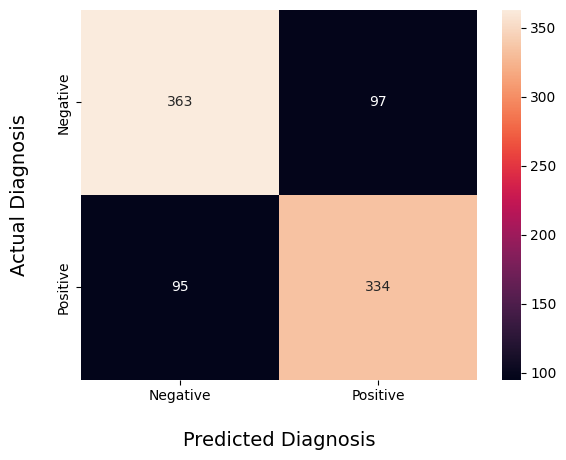

In [52]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns
# {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
xg_political = xgb.XGBClassifier(learning_rate=0.01,
                          max_depth=7,
                          colsample_bytree= 0.5,
                          min_child_weight= 7,
                          subsample= 0.7,

                          objective="reg:squarederror",
                          n_estimators=100)

xg_political.fit(X_train, y_train)
y_pred = xg_political.predict(X_valid)

y_pred_train = xg_political.predict(X_train)


rms_train = mean_squared_error(y_train, y_pred_train)
rms_test = mean_squared_error(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
acc_score = accuracy_score(y_valid, y_pred)
print(f"Mean squared error for train set is {rms_train}")
print(f"Mean squared error for test set is {rms_test}")
print(f"Accuracy Score: {acc_score}")

print("Confusion Matrix:", "\n", confusion)

print(xg_political.feature_importances_)

import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [324]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical

model_political = Sequential()
model_political.add(Dense(30, activation='sigmoid'))
model_political.add(Dense(20, activation='sigmoid', input_dim=6))
model_political.add(Dense(10, activation='sigmoid'))
model_political.add(Dense(1, activation='sigmoid'))

model_political.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=['mean_squared_error']
               )

model_political.fit(X_valid_nlp_scores, y_valid,
            epochs=50,
            batch_size=64
            )
#score = model_political.evaluate(X_valid, y_valid, batch_size=64)
y_res = model_political.predict(X_test_nlp_scores)
y_res = [0 if x < 0 else x for x in y_res]
y_res = [1 if x > 1 else x for x in y_res]

score = mean_squared_error(y_test, y_res)

#print(y_res)
print(score)



Epoch 1/50
11/11 [==============================] - 1s 9ms/step - loss: 0.2785 - mean_squared_error: 0.2785
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 0.2532 - mean_squared_error: 0.2532
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.2392 - mean_squared_error: 0.2392
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.2308 - mean_squared_error: 0.2308
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 0.2263 - mean_squared_error: 0.2263
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 0.2242 - mean_squared_error: 0.2242
Epoch 7/50
11/11 [==============================] - 0s 2ms/step - loss: 0.2230 - mean_squared_error: 0.2230
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 0.2228 - mean_squared_error: 0.2228
Epoch 9/50
11/11 [==============================] - 0s 3ms/step - loss: 0.2225 - mean_squared_error: 0.2225
Epoch 10/50
11/11 [=========

In [168]:
from sklearn.linear_model import LogisticRegression

lr_bot = LogisticRegression()
lr_bot.fit(X_train, y_train)
y_pred_LR = lr_bot.predict(X_valid)

y_pred_train_LR = lr_bot.predict(X_train)

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns

print("Accuracy Score: ", accuracy_score(y_valid, y_pred))
print("MSE VALID: ", mean_squared_error(y_valid, y_pred))

print("Confusion Matrix: ")
sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d')


ValueError: Found input variables with inconsistent numbers of samples: [889, 711]

## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [46]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [47]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')
dfBotAll_train = dfBotAll_train.dropna()
dfBotAll_train.head(5)

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,user_tweet_count,user_average_tweet_day,user_favourites_count,retweet_total_ratio,num_median_favorites,num_of_tweets,unique_tweet_ratio,mention_ratio,hashtag_ratio,retweet_unique_user_ratio,tweet_len_ratio,screen_name,isBot
0,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,42771,49.907818,15474,0.125000,0.0,200.0,1.000,0.840000,0.000000,1.190476,39.605000,scorpiehoez,No
1,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,14300,10.384895,18220,0.910000,0.0,200.0,0.995,2.750000,1.240000,3.956522,121.570000,yusufak63712920,No
2,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,21303,8.373821,26999,0.015306,1.0,196.0,1.000,0.290816,0.010204,1.000000,83.020408,nedenburdaysam,No
3,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,1629,0.488749,2179,0.659898,0.0,197.0,1.000,0.923858,0.446701,1.625000,119.421320,biologselim,No
4,1374314782669606921,Aytaç Aslan,aytaasl07787580,"Şehitkamil, Gaziantep",,1486,1566,0,0.486894,11661,17.561747,8421,0.390000,0.0,200.0,0.915,2.200000,0.145000,5.200000,119.320000,aytaasl07787580,No


In [48]:
trainingUserDf.isBot.value_counts()

No     2717
Yes     701
Name: isBot, dtype: int64

### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [49]:
X = dfBotAll_train[['description_len', 'retweet_total_ratio',  'user_average_tweet_day', 'unique_tweet_ratio',  'user_followers_count', 'user_friends_count', 'followers_to_all_ratio',   'hashtag_ratio',  'tweet_len_ratio']]
y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

In [54]:
X.head(5)

,description_len,retweet_total_ratio,user_average_tweet_day,unique_tweet_ratio,user_followers_count,user_friends_count,followers_to_all_ratio,hashtag_ratio,tweet_len_ratio
0,19,0.125000,49.907818,1.000,8235,3011,0.732260,0.000000,39.605000
1,64,0.910000,10.384895,0.995,95,399,0.192308,1.240000,121.570000
2,65,0.015306,8.373821,1.000,40,83,0.325203,0.010204,83.020408
3,23,0.659898,0.488749,1.000,100,98,0.505051,0.446701,119.421320
4,0,0.390000,17.561747,0.915,1486,1566,0.486894,0.145000,119.320000


#### Oversampling

In [50]:
print("Before OverSampling, counts of label '1': {}".format(sum( y== 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X, y.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))

Before OverSampling, counts of label '1': 698
Before OverSampling, counts of label '0': 2638 

After OverSampling, the shape of train_X: (5276, 9)
After OverSampling, the shape of train_y: (5276,) 

After OverSampling, counts of label '1': 2638
After OverSampling, counts of label '0': 2638


### 2.2.3. Train-test split

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.2.4. Train the model

#### 2.2.4.1 Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# import xgboost as xgb
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 5, 7, 10, 12,15],
#         'min_child_weight': [1, 3, 5, 7],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.3,0.4, 0.5, 0.7],
#         'n_estimators' : [100],
#         'objective': ['reg:squarederror']
#     }

#     xgb_model = xgb.XGBClassifier()

#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            #scoring = 'neg_mean_absolute_error', #MAE
#                            scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

#     gsearch.fit(X_train,y_train)
#     return gsearch.best_params_
# best_params = hyperParameterTuning(X_train,y_train)
# print(best_params)

#### 2.2.4.2 Train Model

In [77]:
#### ADABOOST ####
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
# Create the base model
base_model_1 = DecisionTreeRegressor()
base_model_2 = LinearRegression()
base_model_3 = LogisticRegression()
base_model_4 = SVR()
base_models = [base_model_1, base_model_2]

# Create the ensemble model
ensemble_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.001, random_state=42, loss="square")

# Fit the ensemble model to the training data
ensemble_model.fit(X_train, y_train)

# Predict using the ensemble model on the test data
y_pred = ensemble_model.predict(X_valid)
y_pred = [0 if x < 0 else x for x in y_pred]
y_pred = [1 if x > 1 else x for x in y_pred]

# Evaluate the ensemble model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error: {:.4f}".format(mse))


Mean Squared Error: 0.1171


In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

lr_bot = LinearRegression()
lr_bot.fit(X_train, y_train)
y_pred_LR = lr_bot.predict(X_valid)

y_pred_train_LR = lr_bot.predict(X_train)

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns

#print(y_pred_LR)
y_pred_LR = [0 if x < 0 else x for x in y_pred_LR]
y_pred_LR = [1 if x > 1 else x for x in y_pred_LR]

print("MSE VALID: ", mean_squared_error(y_valid, y_pred_LR))


MSE VALID:  0.12282631656889305


In [100]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical

model_bot = Sequential()
model_bot.add(Dense(40, activation='sigmoid', input_dim=9))
model_bot.add(Dense(30, activation='sigmoid'))
model_bot.add(Dense(20, activation='sigmoid'))
model_bot.add(Dense(10, activation='sigmoid'))
model_bot.add(Dense(1, activation='sigmoid'))

model_bot.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=['mean_squared_error'])

model_bot.fit(X_train, y_train,
            epochs=50,
            batch_size=64)
score_train = model_bot.evaluate(X_train, y_train, batch_size=64)
print(score_train)
score = model_bot.evaluate(X_valid, y_valid, batch_size=64)
print(score)

Epoch 1/50
42/42 [==============================] - 1s 2ms/step - loss: 0.2827 - mean_squared_error: 0.2827
Epoch 2/50
42/42 [==============================] - 0s 3ms/step - loss: 0.1976 - mean_squared_error: 0.1976
Epoch 3/50
42/42 [==============================] - 0s 3ms/step - loss: 0.1745 - mean_squared_error: 0.1745
Epoch 4/50
42/42 [==============================] - 0s 2ms/step - loss: 0.1699 - mean_squared_error: 0.1699
Epoch 5/50
42/42 [==============================] - 0s 2ms/step - loss: 0.1696 - mean_squared_error: 0.1696
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.1696 - mean_squared_error: 0.1696
Epoch 7/50
42/42 [==============================] - 0s 2ms/step - loss: 0.1695 - mean_squared_error: 0.1695
Epoch 8/50
42/42 [==============================] - 0s 2ms/step - loss: 0.1695 - mean_squared_error: 0.1695
Epoch 9/50
42/42 [==============================] - 0s 2ms/step - loss: 0.1695 - mean_squared_error: 0.1695
Epoch 10/50
42/42 [=========

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report


#best fit
#{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}


xg_bot = xgb.XGBClassifier(learning_rate=0.01,
                          max_depth=7,
                          colsample_bytree= 0.7,
                          min_child_weight= 5,
                          subsample= 0.7,
                          objective="reg:squarederror",
                          n_estimators=100)

xg_bot.fit(X_train, y_train)
y_pred = xg_bot.predict(X_valid)
y_pred_train = xg_bot.predict(X_train)

#xg_reg.feature_importances_
rms_train = mean_squared_error(y_train, y_pred_train)
rms_test = mean_squared_error(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
acc_score = accuracy_score(y_valid, y_pred)

print(f"Mean squared error for train set is {rms_train}")
print(f"Mean squared error for test set is {rms_test}")
print(f"Accuracy Score: {acc_score}")
print(classification_report(y_valid,y_pred))
xg_bot.feature_importances_

Mean squared error for train set is 0.08920539730134933
Mean squared error for test set is 0.15868263473053892
Accuracy Score: 0.8413173652694611
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       547
           1       0.59      0.39      0.47       121

    accuracy                           0.84       668
   macro avg       0.73      0.66      0.69       668
weighted avg       0.82      0.84      0.83       668



array([0.0892246 , 0.10014729, 0.13101342, 0.14958064, 0.10367543,
       0.07530786, 0.09759465, 0.08261886, 0.17083724], dtype=float32)

In [ ]:
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [ ]:
# create an instance
# dtc_bot = DecisionTreeClassifier()

# # fit your model
# dtc_bot.fit(X_train, y_train)

# # make predictions
# preds = dtc_bot.predict(X_valid)
# evaluate on validation set
# acc_score = accuracy_score(y_valid, preds)
# confusion = confusion_matrix(y_valid, preds)

# print("MSE:", mse, "\n",
#       "Accuracy Score:", acc_score, "\n",
#       "Confusion Matrix:", "\n", confusion)

# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [86]:
dfPolitical.shape

(33533, 19)

In [85]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('{}evaluation-round{}-tweet.csv'.format(PATH_TO_DOWNLOADED,ROUND), dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# # define X as we did above in section (2.x.2. Separate X and y values)

X = dfPolitical_test[['text_length','num_mentions',
                          'num_retweets',
                        'user_description_political','num_political_entities']]
# # make predictions based on these variables
predictions_political = xg_political.predict(X)

ValueError: Feature shape mismatch, expected: 6, got 5

### This part is important! We expect you to return your predictions in the following format:

In [ ]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
#modelPredTweet

## 3.2. Predictions for Users (Bot or Not)

In [ ]:
evaluationUserDf = pd.read_csv('{}evaluation-round{}-user.csv'.format(PATH_TO_DOWNLOADED,ROUND), dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfBot_test[['description_len', 'retweet_total_ratio',  'user_average_tweet_day', 'unique_tweet_ratio',  'user_followers_count', 'user_friends_count', 'followers_to_all_ratio',   'hashtag_ratio',  'tweet_len_ratio']]
# make predictions based on these variables
predictions_bot = xg_bot.predict(X)

In [ ]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
#modelPredUser

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [ ]:
# Explain your approach

data_explanations = '''
As a group, we combined our data with the data that given to us. After this we used this combined data to train our model. As usual, we used 
80% of the data for the training and 20% for the validation.  
'''

feature_explanations = '''
We used the following features for the training of our political tweet prediction model: 
text_length: length of the tweet
num_mentions: number of mentions in the tweet
num_retweets: number of retweets
user_description_political: political word count in the user description
num_political_entities: political word count in the text

For the bot prediction model, we used the following features:
description_len: length of the description in user profile
retweet_total_ratio: ratio of retweets to total tweets
user_average_tweet_day: tweet count per day => total number of tweets / total number of days
unique_tweet_ratio: number of unique tweets / total number of tweets
user_followers_count: follower count of the user
user_friends_count: following count of the user
followers_to_all_ratio: follower count / (following count + follower count)
hashtag_ratio: hashtag ratio per tweet => hashtag_count / tweet_count
tweet_len_ratio: average tweet length per tweet
'''

model_explanations = '''
We used XGBoost classifier for both of our models. We used the following parameters for the political tweet prediction model:
learning_rate=0.01
max_depth=7
colsample_bytree= 0.5
min_child_weight= 7
subsample= 0.7
objective="reg:squarederror"
n_estimators=100

For the bot prediction model, we used the following parameters:
learning_rate=0.01
max_depth=7
colsample_bytree= 0.7
min_child_weight= 5
subsample= 0.7
objective="reg:squarederror"
n_estimators=100

We find these parameters by making hyperparameter tuning.
'''

additional_explanations = '''
Also, we used oversampling to adjust the class distribution of our data set. 
'''


In [ ]:
predictions = {
    'round': ROUND,
    'student_id': STUDENT_ID,
    'user_predictions': modelPredUser,
    'tweet_predictions': modelPredTweet,
    'explanations': {
        'data': data_explanations,
        'feature': feature_explanations,
        'model': model_explanations,
        'other': additional_explanations,
    }
}


with open('predictions-{}_round{}.json'.format(STUDENT_ID, ROUND), 'w') as fl:
    fl.write(json.dumps(predictions, indent=4))

In [ ]:
# Test your submission file

submission = json.load(open('predictions-{}_round{}.json'.format(STUDENT_ID, ROUND), 'r'))
#submission